<a href="https://colab.research.google.com/github/julrods/cyber-bullying-detector/blob/main/1_EDA_and_Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Environment

## Libraries

In [ ]:
pip install transformers

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from IPython.display import display
import re
import unicodedata
import nltk
from nltk.corpus import stopwords
import itertools
from tqdm import tqdm
from transformers import BertTokenizer
import pickle
from sklearn.utils import shuffle

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Functions

In [ ]:
def column_cleaner(df):
    new_df = df[['Text', 'oh_label']].rename(columns={'Text':'text', 'oh_label':'label'})
    new_df = new_df.dropna()
    new_df['label'] = new_df['label'].astype(int)
    return new_df

def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

def clean_stopwords_shortwords(w):
    stopwords_list=stopwords.words('english')
    words = w.split() 
    clean_words = [word for word in words if (word not in stopwords_list) and len(word) > 2]
    return " ".join(clean_words) 

def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())
    w = re.sub(r"([?.!,¿])", r" ", w)
    w = re.sub(r'[" "]+', " ", w)
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)
    w=clean_stopwords_shortwords(w)
    w=re.sub(r'@\w+', '',w)
    return w

In [ ]:
4/1AX4XfWgs-W1hXMm1liJOv940kJgAoGzdNmNDZF735NzFM4yt_dt8Ll-3Z6A

# Training datasets

## Importing the data

In [ ]:
aggression_original = pd.read_csv('/content/gdrive/MyDrive/Cyber-bullying-project/data/1_raw_data/aggression_parsed_dataset.csv')
attack_original = pd.read_csv('/content/gdrive/MyDrive/Cyber-bullying-project/data/1_raw_data/attack_parsed_dataset.csv')
kaggle_original = pd.read_csv('/content/gdrive/MyDrive/Cyber-bullying-project/data/1_raw_data/kaggle_parsed_dataset.csv')
toxicity_original = pd.read_csv('/content/gdrive/MyDrive/Cyber-bullying-project/data/1_raw_data/toxicity_parsed_dataset.csv')
twitter_original = pd.read_csv('/content/gdrive/MyDrive/Cyber-bullying-project/data/1_raw_data/twitter_parsed_dataset.csv')
racism_original = pd.read_csv('/content/gdrive/MyDrive/Cyber-bullying-project/data/1_raw_data/twitter_racism_parsed_dataset.csv')
sexism_original = pd.read_csv('/content/gdrive/MyDrive/Cyber-bullying-project/data/1_raw_data/twitter_sexism_parsed_dataset.csv')
youtube_original = pd.read_csv('/content/gdrive/MyDrive/Cyber-bullying-project/data/1_raw_data/youtube_parsed_dataset.csv')

In [ ]:
aggression = aggression_original.copy()
attack = attack_original.copy()
kaggle = kaggle_original.copy()
toxicity = toxicity_original.copy()
twitter = twitter_original.copy()
racism = racism_original.copy()
sexism = sexism_original.copy()
youtube = youtube_original.copy()

In [ ]:
df_list = [aggression, attack, kaggle, toxicity, twitter, racism, sexism, youtube]
df_names = ['Aggression', 'Attack', 'Kaggle', 'Toxicity', 'Twitter', 'Racism', 'Sexism', 'Youtube']

In [ ]:
for df_name, df in zip(df_names, df_list):
  print(f'\n {df_name}:')
  display(df.head(3))
  display(df.tail(3))


 Aggression:


,index,Text,ed_label_0,ed_label_1,oh_label
0,0,`- This is not ``creative``. Those are the di...,0.9,0.1,0
1,1,` :: the term ``standard model`` is itself le...,1.0,0.0,0
2,2,"True or false, the situation as of March 200...",1.0,0.0,0


,index,Text,ed_label_0,ed_label_1,oh_label
115861,115861,:The way you're trying to describe it in this...,1.0,0.0,0
115862,115862,== Warning == There is clearly a protection...,0.5,0.5,0
115863,115863,Alternate option=== Is there perhaps enough ne...,1.0,0.0,0



 Attack:


,index,Text,ed_label_0,ed_label_1,oh_label
0,0,`- This is not ``creative``. Those are the di...,1.0,0.0,0
1,1,` :: the term ``standard model`` is itself le...,1.0,0.0,0
2,2,"True or false, the situation as of March 200...",1.0,0.0,0


,index,Text,ed_label_0,ed_label_1,oh_label
115861,115861,:The way you're trying to describe it in this...,1.0,0.0,0
115862,115862,== Warning == There is clearly a protection...,0.8,0.2,0
115863,115863,Alternate option=== Is there perhaps enough ne...,1.0,0.0,0



 Kaggle:


,index,oh_label,Date,Text
0,0,1,20120618192155Z,"""You fuck your dad."""
1,1,0,20120528192215Z,"""i really don't understand your point.\xa0 It ..."
2,2,0,NaN,"""A\\xc2\\xa0majority of Canadians can and has ..."


,index,oh_label,Date,Text
8796,8796,0,20120528234613Z,"""Question: Are you a boy or a girl?"""
8797,8797,1,20120619153537Z,"""Leave your email or phone number and maybe yo..."
8798,8798,0,20120620000237Z,"""From the scenarios you present, I see you bel..."



 Toxicity:


,index,Text,ed_label_0,ed_label_1,oh_label
0,0,This: :One can make an analogy in mathematical...,0.9,0.1,0
1,1,` :Clarification for you (and Zundark's righ...,1.0,0.0,0
2,2,Elected or Electoral? JHK,1.0,0.0,0


,index,Text,ed_label_0,ed_label_1,oh_label
159683,159683,:The way you're trying to describe it in this...,1.0,0.0,0
159684,159684,== Warning == There is clearly a protection...,0.6,0.4,0
159685,159685,Alternate option=== Is there perhaps enough ne...,1.0,0.0,0



 Twitter:


,index,id,Text,Annotation,oh_label
0,5.74948705591165E+017,5.74948705591165E+017,@halalflaws @biebervalue @greenlinerzjm I read...,none,0.0
1,5.71917888690393E+017,5.71917888690393E+017,@ShreyaBafna3 Now you idiots claim that people...,none,0.0
2,3.90255841338601E+017,3.90255841338601E+017,"RT @Mooseoftorment Call me sexist, but when I ...",sexism,1.0


,index,id,Text,Annotation,oh_label
16848,5.72326950057845E+017,5.72326950057845E+017,RT @colonelkickhead: Deconstructed lemon tart!...,none,0.0
16849,5.74799612642357E+017,5.74799612642357E+017,@versacezaynx @nyazpolitics @greenlinerzjm You...,none,0.0
16850,5.68826121153684E+017,5.68826121153684E+017,"And before you protest that you're *not* mad, ...",none,0.0



 Racism:


,index,id,Text,Annotation,oh_label
0,5.767493e+17,5.767493e+17,@AAlwuhaib1977 Muslim mob violence against Hin...,racism,1
1,5.408905e+17,5.408905e+17,@Te4m_NiGhtM4Re http://t.co/5Ih7MkDbQG,none,0
2,5.678433e+17,5.678433e+17,@jncatron @isra_jourisra @AMPalestine Islamoph...,racism,1


,index,id,Text,Annotation,oh_label
13468,5.755969e+17,5.755969e+17,Glad the proper competition is starting and ev...,none,0
13469,5.755990e+17,5.755990e+17,"No worries Pete and Manu, take all the time of...",none,0
13470,5.755977e+17,5.755977e+17,@mykitchenrules #mkr please kick off that lady...,none,0



 Sexism:


,index,id,Text,Annotation,oh_label
0,5.35198627292254E+017,5.35198627292254E+017,RT @BeepsS: @senna1 @BeepsS: I'm not sexist bu...,sexism,1.0
1,5.75984924030714E+017,5.75984924030714E+017,There's some very hate able teams this year #MKR,none,0.0
2,5.7233536016588E+017,5.7233536016588E+017,"RT @The_Eccles: ""Everyone underestimated us"" \...",none,0.0


,index,id,Text,Annotation,oh_label
14878,5.54705698508919E+017,5.54705698508919E+017,@Dartanveerahmad @Janx53 @geehall1 We want ISI...,none,0.0
14879,5.7560079584598E+017,5.7560079584598E+017,#mkr Unbelievable how low Kat &amp; Andre wil...,none,0.0
14880,5.67826532711862E+017,5.67826532711862E+017,RT @JamesMakienko: @omeisy @yemenrightsmon Peo...,none,0.0



 Youtube:


,index,UserIndex,Text,Number of Comments,Number of Subscribers,Membership Duration,Number of Uploads,Profanity in UserID,Age,oh_label
0,0,X1,Does N.e.bodyelse Hear her Crazy ass Screamin ...,10,1,3,3,0,15,0
1,1,X2,There are so many things that are incorrect wi...,3,0,6,5,0,31,0
2,2,X3,3:26 hahah my boyfriend showed this song to me...,7,0,3,5,0,43,1


,index,UserIndex,Text,Number of Comments,Number of Subscribers,Membership Duration,Number of Uploads,Profanity in UserID,Age,oh_label
3461,3466,X3467,JR so cute EXO M Better I agree like yeah yeah...,23,0,5,3,0,33,0
3462,3467,X3468,! !,5,0,6,5,0,38,0
3463,3468,X3469,great video and MERRY CHRISTMAS from greece :*...,27,220,4,30,0,18,0


Insights: 
- We can see that all the datasets have two columns in common: Text and oh_label. We will keep these columns only. 
- We can also see that aggression and attack have the same instances, but with different values in the labels.

## EDA 

### Target class imbalances

In [ ]:
plt.rcParams["figure.figsize"] = (13, 18)

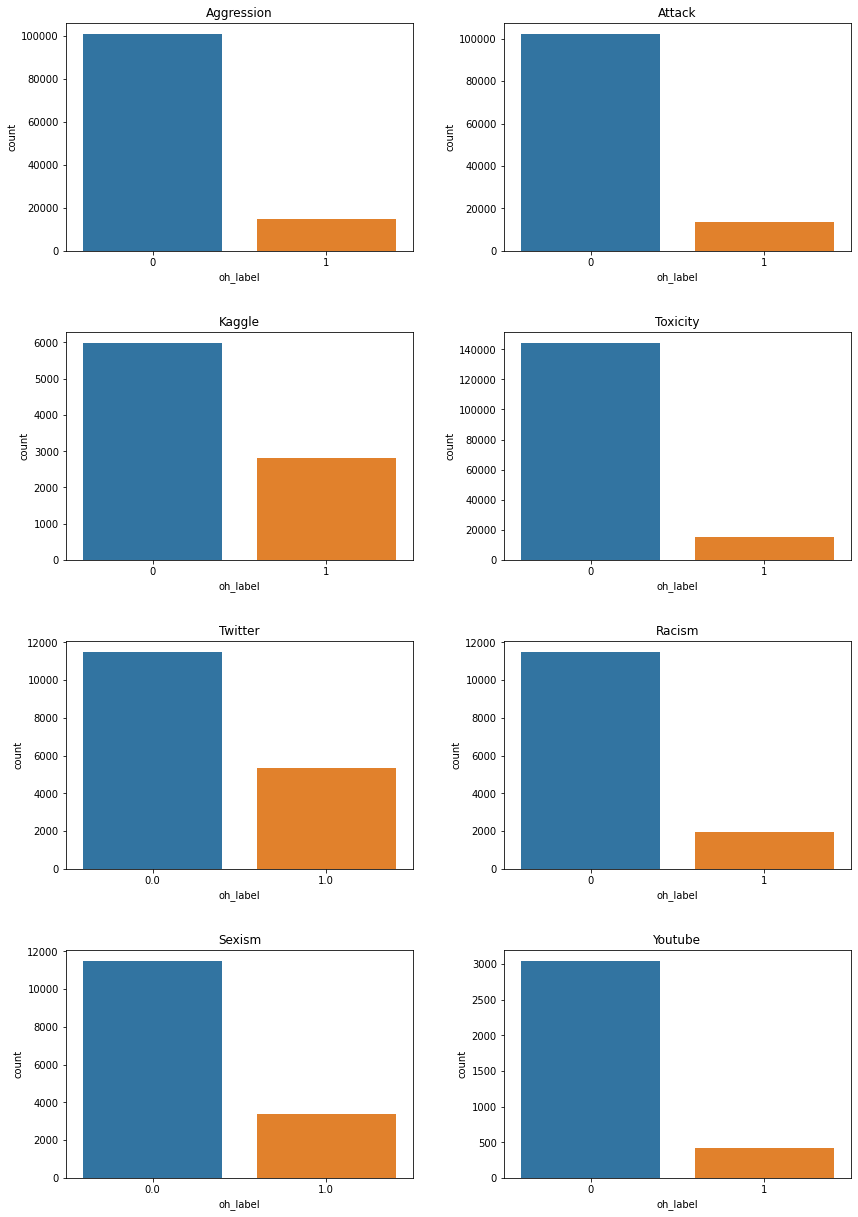

In [ ]:
fig, axes = plt.subplots(4, 2)
fig.tight_layout(pad=6)
for ax, df, df_name in zip(axes.flatten(), df_list, df_names):
    sns.countplot(data=df, x='oh_label', ax=ax)
    ax.set(title=df_name)

Insights: all the datasets have class imbalance. In the case of Twitter and Kaggle.

### Null values

In [ ]:
for df_name, df in zip(df_names, df_list):
  null_values = df[['Text', 'oh_label']].isna().sum()
  print(f'{df_name} has {null_values[0]} null values in Text and {null_values[1]} null values in oh_label')

Aggression has 0 null values in Text and 0 null values in oh_label
Attack has 0 null values in Text and 0 null values in oh_label
Kaggle has 0 null values in Text and 0 null values in oh_label
Toxicity has 0 null values in Text and 0 null values in oh_label
Twitter has 1 null values in Text and 3 null values in oh_label
Racism has 0 null values in Text and 0 null values in oh_label
Sexism has 1 null values in Text and 3 null values in oh_label
Youtube has 0 null values in Text and 0 null values in oh_label


Insight: there are very few null values, we can drop the instances without losing a lot of data

## Preprocessing

In [ ]:
# Remove unnecessary columns, drop null values, rename columns

aggression = column_cleaner(aggression)
attack = column_cleaner(attack)
kaggle = column_cleaner(kaggle)
toxicity = column_cleaner(toxicity)
twitter = column_cleaner(twitter)
racism = column_cleaner(racism)
sexism = column_cleaner(sexism)
youtube = column_cleaner(youtube)

In [ ]:
aggression.head()

,text,label
0,`- This is not ``creative``. Those are the di...,0
1,` :: the term ``standard model`` is itself le...,0
2,"True or false, the situation as of March 200...",0
3,"Next, maybe you could work on being less cond...",0
4,This page will need disambiguation.,0


In [ ]:
# Text preprocessing

df_list = [aggression, attack, kaggle, toxicity, twitter, racism, sexism, youtube]

for df in df_list: 
  df['text'] = df['text'].map(preprocess_sentence)

In [ ]:
for df_name, df in zip(df_names, df_list):
  print(f'\n {df_name}:')
  display(df.head(3))


 Aggression:


,text,label
0,creative dictionary definitions terms insuranc...,0
1,term standard model less npov think prefer new...,0
2,true false situation march saudi proposal land...,0



 Attack:


,text,label
0,creative dictionary definitions terms insuranc...,0
1,term standard model less npov think prefer new...,0
2,true false situation march saudi proposal land...,0



 Kaggle:


,text,label
0,fuck dad,1
1,really understand point seems mixing apples or...,0
2,majority canadians wrong nunless supportive id...,0



 Toxicity:


,text,label
0,one make analogy mathematical terms envisionin...,0
1,clarification zundark right checked wikipedia ...,0
2,elected electoral jhk,0



 Twitter:


,text,label
0,halalflaws biebervalue greenlinerzjm read cont...,0
1,shreyabafna idiots claim people tried stop bec...,0
2,mooseoftorment call sexist auto place rather t...,1



 Racism:


,text,label
0,aalwuhaib muslim mob violence hindus banglades...,1
1,nightm http mkdbqg,0
2,jncatron isra jourisra ampalestine islamophobi...,1



 Sexism:


,text,label
0,beepss senna beepss sexist fuck woman cook get...,1
1,hate able teams year mkr,0
2,eccles everyone underestimated still well unde...,0



 Youtube:


,text,label
0,bodyelse hear crazy ass screamin hoe everytime...,0
1,many things incorrect comment unbelievable gun...,0
2,hahah boyfriend showed song love tooo seizure ...,1


In [ ]:
# Save the clean files

for df, df_name in zip(df_list, df_names):
  df_shuffled = shuffle(df)
  df_shuffled.to_csv(f'/content/gdrive/MyDrive/Cyber-bullying-project/data/2_clean_data/{df_name.lower()}.csv', index=False)

## Tokenization

In [ ]:
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

In [ ]:
# Loop through all the dataframes
for df, df_name in zip(df_list, df_names):
  sentences = df['text']
  labels = df['label']
  input_ids = []
  attention_masks = []

  # Tokenize every sentence in each dataframe
  for sent in sentences:
      bert_inp = bert_tokenizer.encode_plus(sent,
                                            add_special_tokens = True,
                                            max_length = 100,
                                            truncation = True,
                                            padding = 'max_length',
                                            return_attention_mask = True)
      # Append every sentence vector to a list
      input_ids.append(bert_inp['input_ids'])
      attention_masks.append(bert_inp['attention_mask'])
  
  # Convert the lists to arrays so that we can input them into the model
  input_ids = np.asarray(input_ids)
  attention_masks = np.array(attention_masks)
  labels = np.array(labels)

  ### Saving the vectors with pickle
  # Setting the path and filename
  pickle_inp_path = f'/content/gdrive/MyDrive/Cyber-bullying-project/data/3_tokenized_data/bert_inp_{df_name.lower()}.pkl'
  pickle_mask_path = f'/content/gdrive/MyDrive/Cyber-bullying-project/data/3_tokenized_data/bert_mask_{df_name.lower()}.pkl'
  pickle_label_path = f'/content/gdrive/MyDrive/Cyber-bullying-project/data/3_tokenized_data/bert_label_{df_name.lower()}.pkl'

  # Saving the pickle files
  pickle.dump((input_ids), open(pickle_inp_path,'wb'))
  pickle.dump((attention_masks), open(pickle_mask_path,'wb'))
  pickle.dump((labels), open(pickle_label_path,'wb'))

# Evaluation dataset

This files were obtained by scraping Kevin Spacey's Instagram account with the Instaload library. I used the following code on the terminal:

instaloader profile kevinspacey --login my_username --comments

## Loading the files

In [ ]:
path_eval_data = '/content/gdrive/MyDrive/Cyber-bullying-project/data/4_evaluation_data/'
json_files = [file for file in os.listdir(path_eval_data) if file.endswith('.json')]
print(json_files)

['2020-12-24_18-02-58_UTC_comments.json', '2019-12-24_16-50-14_UTC_comments.json', '2018-12-24_18-09-51_UTC_comments.json']


In [ ]:
eval_data = pd.DataFrame()
for file in json_files: 
  with open(path_eval_data + file) as json_file:
    data = json.load(json_file)
    eval_data = pd.concat([eval_data, pd.DataFrame(data)])

In [ ]:
eval_data.reset_index(inplace=True, drop=True)

## EDA

In [ ]:
eval_data.head()

,id,created_at,text,owner,likes_count,answers
0,17875427138446700,1627378729,HaP Birthday Dearest 💋💜,"{'id': '4125351039', 'is_verified': False, 'pr...",0,[]
1,17905589084044186,1627377144,The king 👑 i love you so much ❤️,"{'id': '17784338570', 'is_verified': False, 'p...",1,[]
2,17849306483621406,1627372513,"Happy Birthday, i hope you have the best time ...","{'id': '47642297991', 'is_verified': False, 'p...",0,[]
3,17882985866411568,1627370833,Happy birthday dear @kevinspacey love you!!,"{'id': '199812859', 'is_verified': False, 'pro...",0,[]
4,17899769894128303,1627367577,Happy Belated Birthday @kevinspacey !!!!,"{'id': '46757557', 'is_verified': False, 'prof...",0,[]


In [ ]:
eval_data.tail()

,id,created_at,text,owner,likes_count,answers
22726,17922947536248582,1545675028,Welcome back,"{'id': '2236619845', 'is_verified': False, 'pr...",2,[]
22727,17923740298250598,1545675023,♥♥♥,"{'id': '2057906816', 'is_verified': False, 'pr...",2,[]
22728,17893699225287739,1545675022,👍,"{'id': '1096419929', 'is_verified': False, 'pr...",1,[]
22729,17988600178189879,1545675018,😍,"{'id': '43643802', 'is_verified': False, 'prof...",4,[]
22730,18010496329071098,1545675012,Amazing as always!,"{'id': '3191454488', 'is_verified': False, 'pr...",6,[]


In [ ]:
eval_data.shape

(22731, 6)

In [ ]:
eval_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22731 entries, 0 to 22730
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           22731 non-null  int64 
 1   created_at   22731 non-null  int64 
 2   text         22731 non-null  object
 3   owner        22731 non-null  object
 4   likes_count  22731 non-null  int64 
 5   answers      22731 non-null  object
dtypes: int64(3), object(3)
memory usage: 1.0+ MB


In [ ]:
eval_data.isna().sum()

id             0
created_at     0
text           0
owner          0
likes_count    0
answers        0
dtype: int64

## Preprocessing

In [ ]:
eval_data = shuffle(eval_data).reset_index(drop=True)

In [ ]:
eval_data.head()

,id,created_at,text,owner,likes_count,answers
0,17916298003463538,1599494497,We want you Back,"{'id': '2047340812', 'is_verified': False, 'pr...",0,[]
1,17865878573352424,1616998709,We love and miss you so much 🙌🔥 You have all m...,"{'id': '7415950725', 'is_verified': False, 'pr...",0,[]
2,17856068005684559,1577428392,@lupismojica @rossanayandee @rigom83,"{'id': '338884047', 'is_verified': False, 'pro...",0,[]
3,17867073136573609,1577208381,Hi mel proffitt 👌🤩,"{'id': '208907570', 'is_verified': False, 'pro...",0,[]
4,17864742964898589,1593960135,🍕,"{'id': '460986590', 'is_verified': False, 'pro...",5,[]


In [ ]:
eval_data.tail()

,id,created_at,text,owner,likes_count,answers
22726,17988904840137764,1545832645,Really miss you...☹️😔😣,"{'id': '755994413', 'is_verified': False, 'pro...",0,[]
22727,17991267073303224,1577216310,Welcome back!,"{'id': '14483031184', 'is_verified': False, 'p...",0,[]
22728,17890788385787676,1608834572,🙌,"{'id': '2228469177', 'is_verified': False, 'pr...",0,[]
22729,18015525115009053,1545675189,Merry Christmas Mr.President!,"{'id': '1013534782', 'is_verified': False, 'pr...",1014,[]
22730,17862403607279651,1607602866,❤️,"{'id': '37100995101', 'is_verified': False, 'p...",0,[]


In [ ]:
eval_data['clean_text'] = eval_data['text'].map(preprocess_sentence)

In [ ]:
eval_data.head()

,id,created_at,text,owner,likes_count,answers,clean_text
0,17916298003463538,1599494497,We want you Back,"{'id': '2047340812', 'is_verified': False, 'pr...",0,[],want back
1,17865878573352424,1616998709,We love and miss you so much 🙌🔥 You have all m...,"{'id': '7415950725', 'is_verified': False, 'pr...",0,[],love miss much respect france love
2,17856068005684559,1577428392,@lupismojica @rossanayandee @rigom83,"{'id': '338884047', 'is_verified': False, 'pro...",0,[],lupismojica rossanayandee rigom
3,17867073136573609,1577208381,Hi mel proffitt 👌🤩,"{'id': '208907570', 'is_verified': False, 'pro...",0,[],mel proffitt
4,17864742964898589,1593960135,🍕,"{'id': '460986590', 'is_verified': False, 'pro...",5,[],


Now we see there are some empty strings because some comments contained only emojis, so we have to check for null values again and drop them.

In [ ]:
eval_data = eval_data[eval_data['clean_text'] != '']

In [ ]:
eval_data.shape

(17749, 2)

In [ ]:
eval_data = eval_data[['text', 'clean_text']].reset_index(drop=True)

In [ ]:
eval_data.to_csv(path_eval_data + 'clean_evaluation_data.csv', index=False)

## Tokenization

In [ ]:
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

In [ ]:
sentences = eval_data['clean_text']
input_ids = []
attention_masks = []

# Tokenize every sentence
for sent in sentences:
    bert_inp = bert_tokenizer.encode_plus(sent,
                                          add_special_tokens = True,
                                          max_length = 100,
                                          truncation = True,
                                          padding = 'max_length',
                                          return_attention_mask = True)
    # Append every sentence vector to a list
    input_ids.append(bert_inp['input_ids'])
    attention_masks.append(bert_inp['attention_mask'])

# Convert the lists to arrays so that we can input them into the model
input_ids = np.asarray(input_ids)
attention_masks = np.array(attention_masks)

### Saving the vectors with pickle
# Setting the path and filename
pickle_inp_path = '/content/gdrive/MyDrive/Cyber-bullying-project/data/3_tokenized_data/bert_inp_eval_data.pkl'
pickle_mask_path = '/content/gdrive/MyDrive/Cyber-bullying-project/data/3_tokenized_data/bert_mask_eval_data.pkl'

# Saving the pickle files
pickle.dump((input_ids), open(pickle_inp_path,'wb'))
pickle.dump((attention_masks), open(pickle_mask_path,'wb'))